<a href="https://colab.research.google.com/github/rachelyayra/Electricity-theft-detection-project/blob/main/Final_year_project_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Install the needed packages

In [2]:
pip install tslearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import the needed libraries and packages

In [3]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.combine import SMOTETomek
import math
from tslearn.clustering import TimeSeriesKMeans
from tslearn.barycenters import dtw_barycenter_averaging
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, f1_score

Accessing the data

In [4]:
illegal_path = '/content/drive/My Drive/finalyearprojectdata/illegal_xx.csv'
legal_path = '/content/drive/My Drive/finalyearprojectdata/legal_mm.csv'

In [5]:
illegal_df = pd.read_csv(illegal_path)
legal_df = pd.read_csv(legal_path)
illegal_df = pd.DataFrame(illegal_df.to_numpy()) 
legal_df = pd.DataFrame(legal_df.to_numpy())

Checking for missing Values

In [6]:
legal_df = legal_df.fillna(0)
legal_df.isnull().any().any()

False

In [7]:
legal_row = legal_df
legal_row['label'] = 0
illegal_row = illegal_df
illegal_row['label'] = 1
print(legal_row)

         0      1      2      3      4      5      6      7      8      9  \
0    427.0  355.0  429.0  305.0  435.0  427.0  355.0  429.0  435.0  478.0   
1    331.0  297.0  237.0  326.0  317.0  331.0  297.0  237.0  326.0  317.0   
2    202.0  176.0  220.0  215.0  188.0  202.0  223.0  223.0  222.0  237.0   
3    266.0  225.0  234.0  254.0  224.0  211.0  196.0  258.0  260.0  269.0   
4    292.0  235.0  320.0  371.0  319.0  292.0  235.0  320.0  371.0  319.0   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
308  193.0  241.0  229.0  230.0  224.0  193.0  241.0  229.0  230.0  224.0   
309   17.0   10.0   53.0   80.0    0.0   17.0   10.0   53.0   80.0    0.0   
310  120.0  115.0  124.0  121.0  160.0  120.0  115.0  124.0  121.0  160.0   
311   99.0   99.0  126.0  143.0  110.0  200.0  192.0  212.0  242.0  231.0   
312   55.0   43.0   58.0   60.0   43.0   58.0   60.0   43.0   58.0   60.0   

        10     11  label  
0    429.0  435.0      0  
1    237.0  326.0    

In [8]:
X_points = pd.concat([legal_row, illegal_row])
S_y = X_points['label']
S_X = X_points.drop(columns= 'label')
print(S_X)

        0      1      2      3      4      5      6      7      8      9  \
0   427.0  355.0  429.0  305.0  435.0  427.0  355.0  429.0  435.0  478.0   
1   331.0  297.0  237.0  326.0  317.0  331.0  297.0  237.0  326.0  317.0   
2   202.0  176.0  220.0  215.0  188.0  202.0  223.0  223.0  222.0  237.0   
3   266.0  225.0  234.0  254.0  224.0  211.0  196.0  258.0  260.0  269.0   
4   292.0  235.0  320.0  371.0  319.0  292.0  235.0  320.0  371.0  319.0   
..    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
42    0.0   13.0  171.0  107.0   85.0   82.0   88.0  101.0  153.0  176.0   
43    0.0    0.0    0.0   19.0  438.0  424.0  419.0  391.0  410.0  450.0   
44  192.0   20.0   13.0   64.0    0.0    0.0    0.0    0.0    0.0    0.0   
45    0.0  293.0  318.0  301.0  244.0  204.0  174.0  135.0  174.0  222.0   
46    0.0    0.0    0.0    0.0    0.0   10.0   18.0   16.0   19.0   19.0   

       10     11  
0   429.0  435.0  
1   237.0  326.0  
2   223.0  222.0  
3   258.0  

Split Data into training and test data


In [9]:
X_train, X_test, y_train, y_test = train_test_split(S_X,S_y, test_size=0.4, random_state=702, stratify= S_y)

In [10]:
print(X_test)

         0      1      2      3      4      5      6      7      8      9  \
20    47.0   23.0   33.0   24.0   44.0   47.0   23.0   33.0   24.0   44.0   
132    8.0    9.0   13.0   18.0   10.0   20.0   15.0   16.0   13.0   20.0   
87    60.0   56.0  113.0   49.0  135.0   60.0   43.0  113.0   33.0  135.0   
52    26.0   29.0   30.0   36.0   99.0   78.0   82.0   86.0   36.0   99.0   
13   606.0  589.0  606.0  589.0  531.0  606.0  589.0  606.0  589.0  531.0   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
259   30.0   27.0   25.0    8.0   18.0   30.0   27.0   25.0    8.0   32.0   
80   266.0  286.0  307.0  296.0  244.0  266.0  286.0  289.0  271.0  253.0   
43   129.0  127.0  134.0  122.0  112.0  129.0  136.0  167.0  153.0  177.0   
139  111.0  133.0  115.0  120.0  128.0  111.0  133.0  115.0  132.0  128.0   
264  120.0  116.0  141.0  165.0  136.0  185.0  190.0  196.0  231.0  228.0   

        10     11  
20    33.0   24.0  
132   16.0   13.0  
87   113.0   33

To balance the training data, SMOTE with Tomek Links is used


In [11]:
smt = SMOTETomek(random_state=42)
X_train, y_train = smt.fit_resample(X_train, y_train)
train = pd.DataFrame.copy(X_train)
X_train['label'] = y_train

In [12]:
X_train

,0,1,2,3,4,5,6,7,8,9,10,11,label
0,19.000000,19.000000,115.000000,58.000000,29.00000,19.000000,19.000000,115.000000,58.000000,29.000000,115.000000,58.000000,0
1,27.000000,24.000000,37.000000,40.000000,30.00000,22.000000,27.000000,24.000000,6.000000,29.000000,24.000000,6.000000,0
2,30.000000,28.000000,32.000000,29.000000,36.00000,36.000000,44.000000,40.000000,40.000000,44.000000,40.000000,40.000000,0
3,20.000000,19.000000,35.000000,37.000000,41.00000,20.000000,19.000000,35.000000,37.000000,41.000000,35.000000,37.000000,0
4,7.000000,7.000000,6.000000,13.000000,18.00000,7.000000,0.000000,13.000000,18.000000,27.000000,13.000000,18.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,222.049514,240.717434,222.802204,275.279327,252.41711,251.392353,236.364097,248.473623,204.996501,167.950486,181.134284,239.667920,1
372,55.456401,35.058645,1.912290,0.000000,0.00000,16.573177,22.310047,54.672617,105.239673,101.327383,123.631822,117.421215,1
373,113.582136,87.526494,3.560813,56.739087,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
374,84.899131,53.671864,2.927556,0.000000,0.00000,25.372154,34.154823,66.178971,94.748586,89.821029,151.044018,135.696012,1


In [13]:
legal_df = X_train.loc[X_train['label'] == 0].drop(columns= 'label')
print(legal_df)
illegal_df = X_train.loc[X_train['label'] == 1].drop(columns= 'label')
print(illegal_df)

         0      1      2      3      4      5      6      7      8      9  \
0     19.0   19.0  115.0   58.0   29.0   19.0   19.0  115.0   58.0   29.0   
1     27.0   24.0   37.0   40.0   30.0   22.0   27.0   24.0    6.0   29.0   
2     30.0   28.0   32.0   29.0   36.0   36.0   44.0   40.0   40.0   44.0   
3     20.0   19.0   35.0   37.0   41.0   20.0   19.0   35.0   37.0   41.0   
4      7.0    7.0    6.0   13.0   18.0    7.0    0.0   13.0   18.0   27.0   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
210   17.0   17.0   17.0   22.0   17.0   45.0   18.0   17.0   17.0   48.0   
211  263.0  299.0  326.0  226.0  250.0  263.0  299.0  326.0  226.0  250.0   
212   66.0   71.0   80.0   80.0   99.0   80.0   99.0   92.0   88.0  111.0   
213  163.0  178.0  197.0  205.0  106.0  238.0  265.0  205.0  106.0  110.0   
214  170.0  223.0  248.0  238.0  199.0  170.0  194.0  126.0  133.0  204.0   

        10     11  
0    115.0   58.0  
1     24.0    6.0  
2     40.0   40

Normalize data points for clustering

In [14]:
scaler = MinMaxScaler()
norm_mm = scaler.fit_transform(legal_df.T)
norm_mm = pd.DataFrame(norm_mm)
norm_mm = norm_mm.T

norm_xx = scaler.fit_transform(illegal_df.T)
norm_xx = pd.DataFrame(norm_xx)
norm_xx = norm_xx.T
print(norm_xx)

           0         1         2         3         4         5         6   \
0    0.000000  0.000000  0.000000  0.015873  0.000000  0.015873  0.000000   
1    0.542751  0.992565  1.000000  0.405204  0.000000  0.000000  0.000000   
2    0.108482  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3    0.000000  0.439834  1.000000  0.800830  0.672199  0.473029  0.488243   
4    1.000000  0.472222  0.638889  0.138889  0.000000  0.000000  0.000000   
..        ...       ...       ...       ...       ...       ...       ...   
183  0.504049  0.677981  0.511062  1.000000  0.786989  0.777441  0.637421   
184  0.448561  0.283573  0.015468  0.000000  0.000000  0.134053  0.180456   
185  1.000000  0.770601  0.031350  0.499542  0.000000  0.000000  0.000000   
186  0.562082  0.355339  0.019382  0.000000  0.000000  0.167979  0.226125   
187  0.171647  0.187251  0.140438  0.061432  0.015604  0.014619  0.000000   

           7         8         9         10        11  
0    0.015873  0.00

In [15]:
clusterX = pd.concat([norm_xx, norm_mm]).reset_index().drop(columns = 'index')

In [16]:
clusterX

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.000000,0.000000,0.000000,0.015873,0.000000,0.015873,0.000000,0.015873,0.000000,0.015873,0.984127,1.000000
1,0.542751,0.992565,1.000000,0.405204,0.000000,0.000000,0.000000,0.000000,0.245353,0.955390,0.959108,0.654275
2,0.108482,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.012118,0.042123,0.030006,0.111368
3,0.000000,0.439834,1.000000,0.800830,0.672199,0.473029,0.488243,0.408022,0.416321,0.383126,0.366528,0.327801
4,1.000000,0.472222,0.638889,0.138889,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
371,0.000000,0.000000,0.000000,0.161290,0.000000,0.903226,0.032258,0.000000,0.000000,1.000000,0.000000,0.000000
372,0.370000,0.730000,1.000000,0.000000,0.240000,0.370000,0.730000,1.000000,0.000000,0.240000,1.000000,0.000000
373,0.000000,0.111111,0.311111,0.311111,0.733333,0.311111,0.733333,0.577778,0.488889,1.000000,0.577778,0.488889
374,0.358491,0.452830,0.572327,0.622642,0.000000,0.830189,1.000000,0.622642,0.000000,0.025157,0.622642,0.000000


Feature Extraction: Coefficient of Variation and Peak and Minimum consumption month


In [17]:
std_mm = legal_df.T.std()
mean_mm = legal_df.T.mean()
features_mm = pd.concat([std_mm, mean_mm], axis = 1)
features_mm["cOfVar"] = features_mm[0]/features_mm[1]
features_mm.drop(columns=[0,1], inplace= True)
features_mm['label'] = 0
print(features_mm)

       cOfVar  label
0    0.730017      0
1    0.414637      0
2    0.154830      0
3    0.286211      0
4    0.597978      0
..        ...    ...
210  0.506654      0
211  0.146602      0
212  0.145100      0
213  0.319624      0
214  0.244694      0

[188 rows x 2 columns]


In [18]:
std_xx = illegal_df.T.std()
mean_xx = illegal_df.T.mean()
features_xx = pd.concat([std_xx, mean_xx], axis = 1)
features_xx["cOfVar"] = features_xx[0]/features_xx[1]
features_xx.drop(columns=[0,1], inplace= True)
features_xx['label'] = 1
print(features_xx)

       cOfVar  label
8    2.249102      1
10   0.890323      1
14   2.610436      1
15   0.522989      1
19   1.782401      1
..        ...    ...
371  0.135505      1
372  0.903445      1
373  1.862068      1
374  0.835881      1
375  1.543225      1

[188 rows x 2 columns]


In [19]:
features_xx['peakMonth'] = illegal_df.T.idxmax().to_numpy()
temp_xx = illegal_df.T.idxmax().to_numpy()
f_xx ={}
for i in temp_xx:
  f_xx[i] = f_xx.get(i, 0) + 1
print(f_xx)
print(features_xx)

{11: 42, 2: 10, 7: 25, 0: 33, 6: 10, 10: 35, 4: 8, 1: 7, 3: 9, 8: 4, 9: 5}
       cOfVar  label  peakMonth
8    2.249102      1         11
10   0.890323      1          2
14   2.610436      1          7
15   0.522989      1          2
19   1.782401      1          0
..        ...    ...        ...
371  0.135505      1          3
372  0.903445      1         10
373  1.862068      1          0
374  0.835881      1         10
375  1.543225      1         10

[188 rows x 3 columns]


In [20]:
features_xx['minMonth'] = illegal_df.T.idxmin().to_numpy()
# temp_xx = illegal_df.idxmin().to_numpy()
# f_xx ={}
# for i in temp_xx:
#   f_xx[i] = f_xx.get(i, 0) + 1
# print(f_xx)
print(features_xx)

       cOfVar  label  peakMonth  minMonth
8    2.249102      1         11         0
10   0.890323      1          2         4
14   2.610436      1          7         1
15   0.522989      1          2         0
19   1.782401      1          0         4
..        ...    ...        ...       ...
371  0.135505      1          3         9
372  0.903445      1         10         3
373  1.862068      1          0         4
374  0.835881      1         10         3
375  1.543225      1         10         6

[188 rows x 4 columns]


In [21]:
features_mm['peakMonth'] = legal_df.T.idxmax().to_numpy()
# temp_xx = legal_df.idxmax().to_numpy()
# f_xx ={}
# for i in temp_xx:
#   f_xx[i] = f_xx.get(i, 0) + 1
# print(f_xx)
print(features_mm)

       cOfVar  label  peakMonth
0    0.730017      0          2
1    0.414637      0          3
2    0.154830      0          6
3    0.286211      0          4
4    0.597978      0          9
..        ...    ...        ...
210  0.506654      0          9
211  0.146602      0          2
212  0.145100      0          9
213  0.319624      0          6
214  0.244694      0          2

[188 rows x 3 columns]


In [22]:
features_mm['minMonth'] = legal_df.T.idxmin().to_numpy()
# temp_xx = legal_df.idxmin().to_numpy()
# f_xx ={}
# for i in temp_xx:
#   f_xx[i] = f_xx.get(i, 0) + 1
# print(f_xx)
print(features_mm)

       cOfVar  label  peakMonth  minMonth
0    0.730017      0          2         0
1    0.414637      0          3         8
2    0.154830      0          6         1
3    0.286211      0          4         1
4    0.597978      0          9         6
..        ...    ...        ...       ...
210  0.506654      0          9         0
211  0.146602      0          2         3
212  0.145100      0          9         0
213  0.319624      0          6         4
214  0.244694      0          2         7

[188 rows x 4 columns]


In [23]:
Xfull = pd.concat([features_xx, features_mm]).reset_index().drop(columns = 'index')
X = Xfull
# X["cOfVar"] = 10*X["cOfVar"]
print(X)

       cOfVar  label  peakMonth  minMonth
0    2.249102      1         11         0
1    0.890323      1          2         4
2    2.610436      1          7         1
3    0.522989      1          2         0
4    1.782401      1          0         4
..        ...    ...        ...       ...
371  0.506654      0          9         0
372  0.146602      0          2         3
373  0.145100      0          9         0
374  0.319624      0          6         4
375  0.244694      0          2         7

[376 rows x 4 columns]


Feature Extruction: Time series cluster

In [24]:
# Clustering
nums = math.ceil(math.sqrt(len(X)/2))
km_dba = TimeSeriesKMeans(n_clusters=nums, metric="dtw", max_iter=5,max_iter_barycenter=10,random_state=1).fit(clusterX)
print(km_dba)
labels = km_dba.labels_

TimeSeriesKMeans(max_iter=5, max_iter_barycenter=10, metric='dtw',
                 n_clusters=14, random_state=1)


In [25]:
print(labels)
clusterX['clabels'] = labels

[ 2  6 11  0  3  9  0  2  2  7  2  9  2  7  3  3  3  0 11  3  0  3  4  2
  2  4  2  3  0 11 11  3  3  3  0  9  6  0  4  3  0  2  2  2  0  2  2  3
  9  3  0  2  9 11  2  3  2  2  2  2  2  3  3  4  2  0  2 11  6  0  2  4
  3  7  2  6  7  3  2  0  2  2  2  2  3  2  2  2 11 11  7 11  6  3  4  2
  3  2  2 11  3  4  0  3  6  7  4  3  2  3  3  3  9  4  9  2  2  2  3 11
  0  9  2  0  3  0  7  6  2  2  3  0  4  3 11  0  2  2  2  3  2  3  2  6
  2  4  3  0  2  7  2  2  9  2  2  3  2  3  2  2  2  7  4  2  9  2  2  2
  0  3  2  2  9  9  3  4  2  9 11  2  4  2  9  6  9  3  9  2 10  1  2  4
  4 13 12 12  8  9 11  2  2  6  5 11  9 10 10  4  9 13  1  8  5  4  7 13
  4  9  0  5  4  5  1  5 13  6  8  1  1  5  5 13 13 10 12  5  6  5  3  4
 10  8  0  1 13 13  2  3  9 11  3  4 11  8  6  1 12 13  8  8  2  8  1 13
  4  4 10 10  6  4  5  4  9 13 10 11  3  4  1 12  4  1  6  5  4  8  3  1
  4  1 10  4 13 13  8  5  1  8 13  1 13 12 10 12 10  8  3  0  5 13  5  1
 11  6 13  6  1 13 11  4  8  8 12  3 13  2  8  5  3

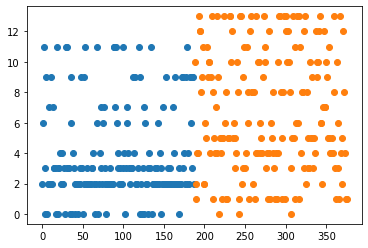

In [26]:
for frame in [clusterX[0:188], clusterX[188:398]]:
  plt.scatter(x = frame.index ,y= frame['clabels'])

410, 11

In [27]:
X['c_labels'] = labels
print(X)

       cOfVar  label  peakMonth  minMonth  c_labels
0    2.249102      1         11         0         2
1    0.890323      1          2         4         6
2    2.610436      1          7         1        11
3    0.522989      1          2         0         0
4    1.782401      1          0         4         3
..        ...    ...        ...       ...       ...
371  0.506654      0          9         0        12
372  0.146602      0          2         3         8
373  0.145100      0          9         0         4
374  0.319624      0          6         4         1
375  0.244694      0          2         7         1

[376 rows x 5 columns]


In [28]:
temp = clusterX[clusterX.columns.difference(["clabels"])]
temp

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.000000,0.000000,0.000000,0.015873,0.000000,0.015873,0.000000,0.015873,0.000000,0.015873,0.984127,1.000000
1,0.542751,0.992565,1.000000,0.405204,0.000000,0.000000,0.000000,0.000000,0.245353,0.955390,0.959108,0.654275
2,0.108482,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.012118,0.042123,0.030006,0.111368
3,0.000000,0.439834,1.000000,0.800830,0.672199,0.473029,0.488243,0.408022,0.416321,0.383126,0.366528,0.327801
4,1.000000,0.472222,0.638889,0.138889,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
371,0.000000,0.000000,0.000000,0.161290,0.000000,0.903226,0.032258,0.000000,0.000000,1.000000,0.000000,0.000000
372,0.370000,0.730000,1.000000,0.000000,0.240000,0.370000,0.730000,1.000000,0.000000,0.240000,1.000000,0.000000
373,0.000000,0.111111,0.311111,0.311111,0.733333,0.311111,0.733333,0.577778,0.488889,1.000000,0.577778,0.488889
374,0.358491,0.452830,0.572327,0.622642,0.000000,0.830189,1.000000,0.622642,0.000000,0.025157,0.622642,0.000000


In [29]:
clusterX

,0,1,2,3,4,5,6,7,8,9,10,11,clabels
0,0.000000,0.000000,0.000000,0.015873,0.000000,0.015873,0.000000,0.015873,0.000000,0.015873,0.984127,1.000000,2
1,0.542751,0.992565,1.000000,0.405204,0.000000,0.000000,0.000000,0.000000,0.245353,0.955390,0.959108,0.654275,6
2,0.108482,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.012118,0.042123,0.030006,0.111368,11
3,0.000000,0.439834,1.000000,0.800830,0.672199,0.473029,0.488243,0.408022,0.416321,0.383126,0.366528,0.327801,0
4,1.000000,0.472222,0.638889,0.138889,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,0.000000,0.000000,0.000000,0.161290,0.000000,0.903226,0.032258,0.000000,0.000000,1.000000,0.000000,0.000000,12
372,0.370000,0.730000,1.000000,0.000000,0.240000,0.370000,0.730000,1.000000,0.000000,0.240000,1.000000,0.000000,8
373,0.000000,0.111111,0.311111,0.311111,0.733333,0.311111,0.733333,0.577778,0.488889,1.000000,0.577778,0.488889,4
374,0.358491,0.452830,0.572327,0.622642,0.000000,0.830189,1.000000,0.622642,0.000000,0.025157,0.622642,0.000000,1


In [30]:
for i in range(20):
    globals()[f"df{i}"] = pd.DataFrame().reset_index().drop(columns = 'index')

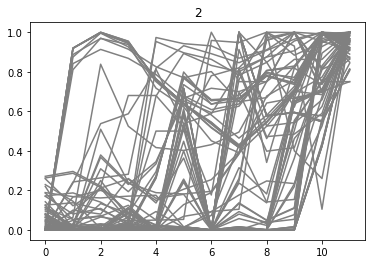

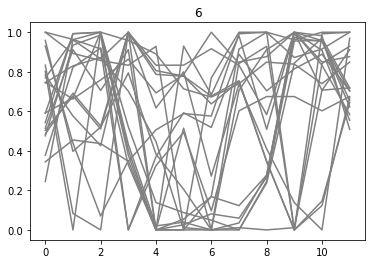

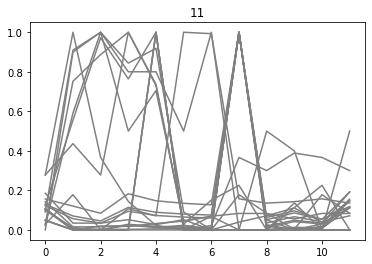

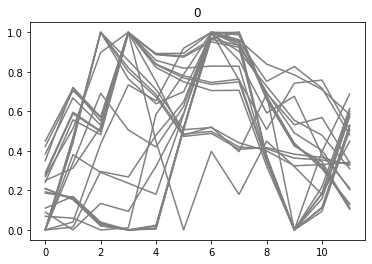

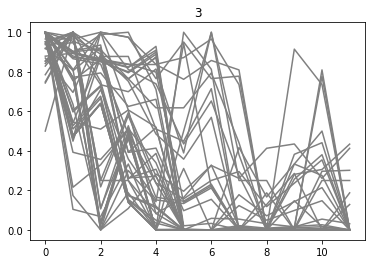

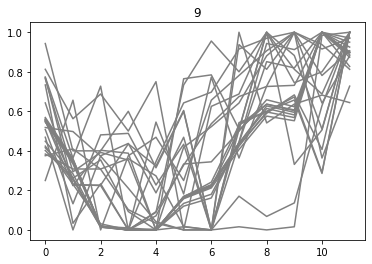

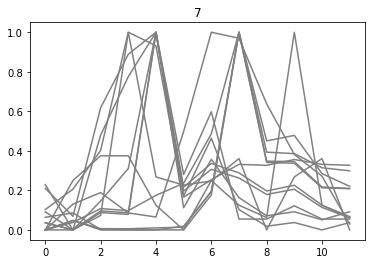

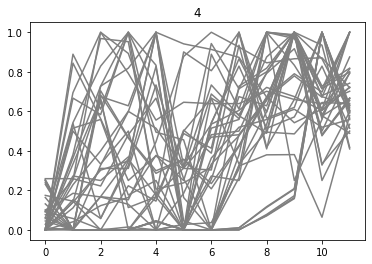

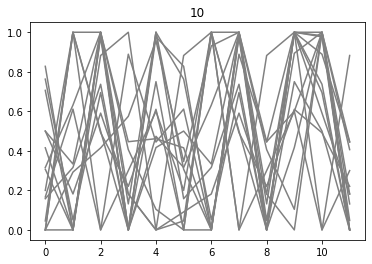

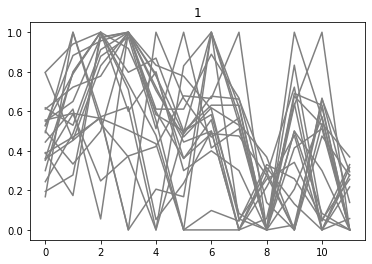

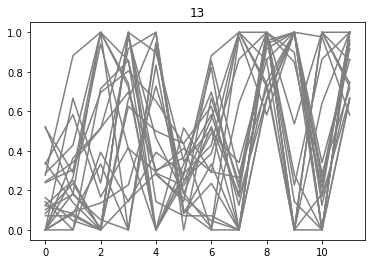

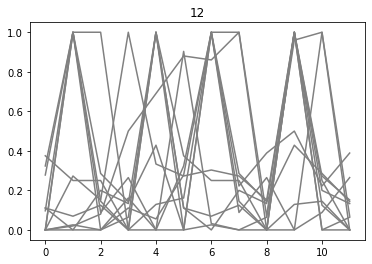

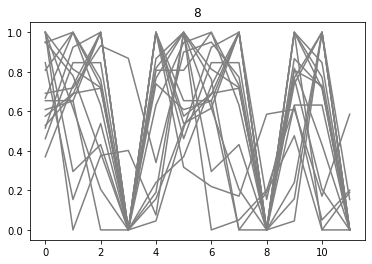

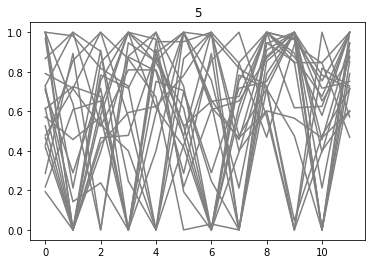

In [31]:
for i in range(len(temp)):
  clus = int(clusterX.loc[i]['clabels'])
  plt.figure(clus)
  plt.title(clus)
  plt.plot( temp.T.index.values, temp.T[i], color = 'gray')
  globals()[f"df{clus}"]= pd.concat([globals()[f"df{clus}"],temp.T[i]],axis=1 )

Average Shape of each Timeseries cluster

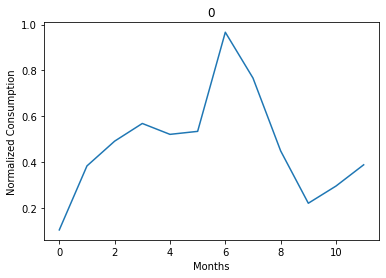

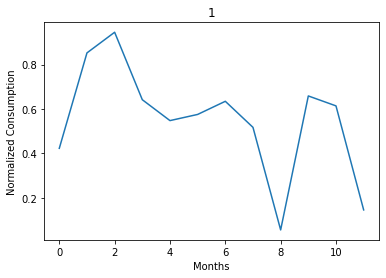

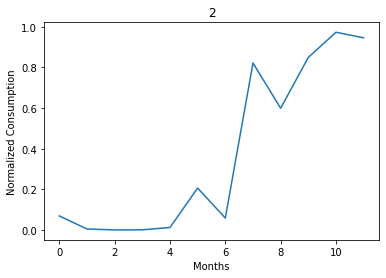

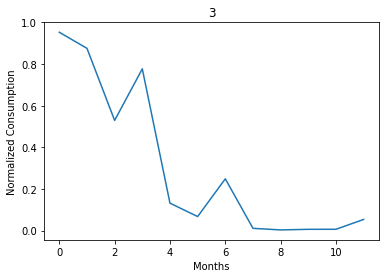

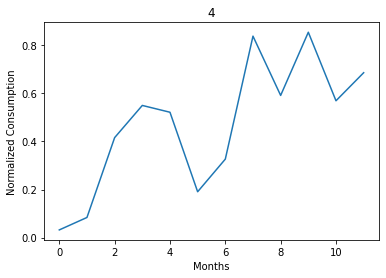

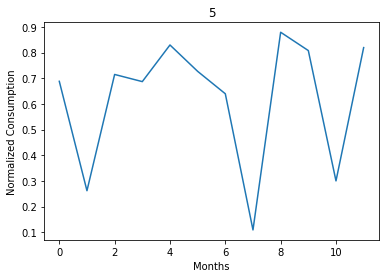

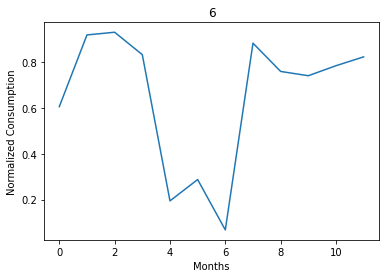

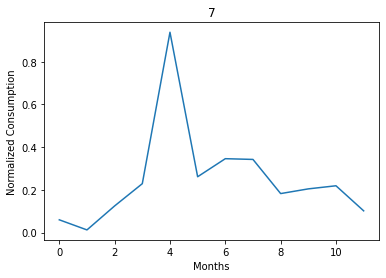

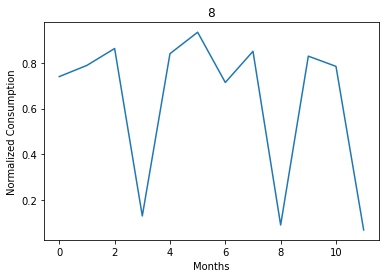

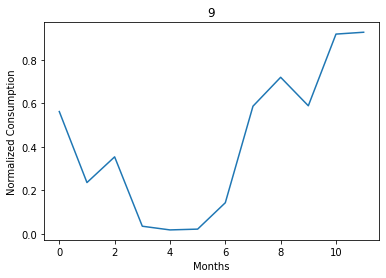

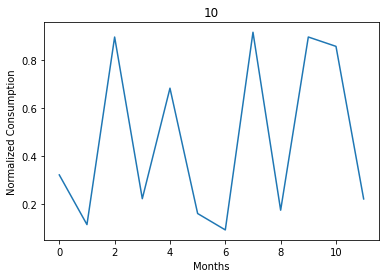

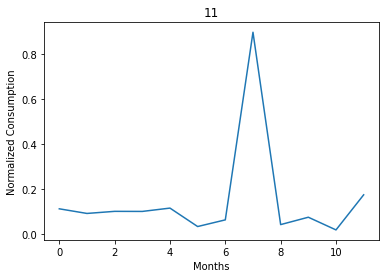

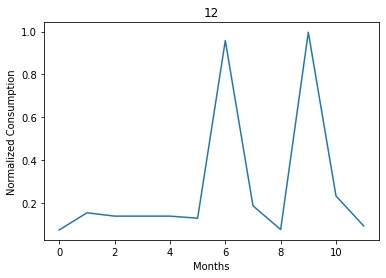

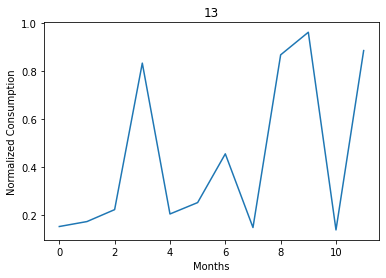

In [32]:
for i in range(nums):
  average = dtw_barycenter_averaging((globals()[f"df{i}"]).T, max_iter=14)
  plt.figure(i)
  plt.title(i)
  plt.xlabel("Months")
  plt.ylabel("Normalized Consumption")
  plt.plot(average)

In [33]:
y = X['label']
X = X.drop(columns = ['label'])

In [34]:
# X['c_labels'].astype('category')
# X['peakMonth'].astype('category')
# X['minMonth'].astype('category')

In [35]:
X

,cOfVar,peakMonth,minMonth,c_labels
0,2.249102,11,0,2
1,0.890323,2,4,6
2,2.610436,7,1,11
3,0.522989,2,0,0
4,1.782401,0,4,3
...,...,...,...,...
371,0.506654,9,0,12
372,0.146602,2,3,8
373,0.145100,9,0,4
374,0.319624,6,4,1


In [36]:
y

0      1
1      1
2      1
3      1
4      1
      ..
371    0
372    0
373    0
374    0
375    0
Name: label, Length: 376, dtype: int64

Preparation of Test Data

In [37]:
Xtest = scaler.fit_transform(X_test.T)

In [38]:
clus_test = pd.DataFrame(Xtest).T
print(clus_test)
print(X_test)

           0         1         2         3         4         5         6   \
0    1.000000  0.000000  0.416667  0.041667  0.875000  1.000000  0.000000   
1    0.000000  0.083333  0.416667  0.833333  0.166667  1.000000  0.583333   
2    0.264706  0.225490  0.784314  0.156863  1.000000  0.264706  0.098039   
3    0.000000  0.041096  0.054795  0.136986  1.000000  0.712329  0.767123   
4    1.000000  0.773333  1.000000  0.773333  0.000000  1.000000  0.773333   
..        ...       ...       ...       ...       ...       ...       ...   
139  0.916667  0.791667  0.708333  0.000000  0.416667  0.916667  0.791667   
140  0.349206  0.666667  1.000000  0.825397  0.000000  0.349206  0.666667   
141  0.261538  0.230769  0.338462  0.153846  0.000000  0.261538  0.369231   
142  0.000000  1.000000  0.181818  0.409091  0.772727  0.000000  1.000000   
143  0.034783  0.000000  0.217391  0.426087  0.173913  0.600000  0.643478   

           7         8         9         10        11  
0    0.416667  0.04

In [39]:
std_mm = X_test.T.std()
mean_mm = X_test.T.mean()
features_test = pd.concat([std_mm, mean_mm], axis = 1)
features_test["cOfVar"] = features_test[0]/features_test[1]
# features_test["cOfVar"] = 10 * features_test["cOfVar"]
features_test.drop(columns=[0,1], inplace= True)
features_test['peakMonth'] = X_test.T.idxmax().to_numpy()
features_test['minMonth'] = X_test.T.idxmin().to_numpy()
new_p = km_dba.predict(clus_test)
features_test['c_labels'] = new_p 
print(features_test)


/usr/local/lib/python3.7/dist-packages/tslearn/utils/utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 144 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


       cOfVar  peakMonth  minMonth  c_labels
20   0.297487          0         1         8
132  0.280901          5         0         4
87   0.506359          4         8        10
52   0.499087          4         0        12
13   0.046254          0         4         5
..        ...        ...       ...       ...
259  0.414755          9         3         8
80   0.066121          2         4         0
43   0.145082          9         4         4
139  0.073699          1         0        10
264  0.236460          8         1         2

[144 rows x 4 columns]


Testing and Evaluation

In [41]:
from sklearn.svm import SVC

svc = SVC(C= 100, kernel = 'rbf')
svc.fit(X, y)

SVC(C=100)

In [42]:
C= [ 1,10,15,20,25,30,100,1000]
kernel = ['rbf', 'linear']
param_grid = dict(C = C,kernel = kernel)
searcher = GridSearchCV(svc, n_jobs=-1, cv=5,
	param_grid=param_grid, scoring="accuracy")
searchResults = searcher.fit(X, y)

In [43]:
print(searchResults.best_score_)
print(searchResults.best_params_)


0.9307368421052633
{'C': 100, 'kernel': 'rbf'}


0.9623655913978495


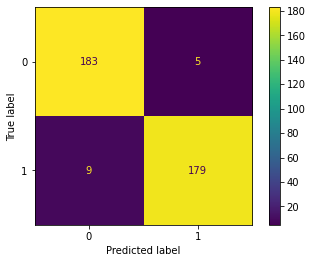

In [44]:
#Training 
prediction_train = svc.predict(X)
cm_t = confusion_matrix(y, prediction_train, labels=svc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_t, display_labels=svc.classes_)
disp.plot()
print(f1_score(y, prediction_train))

0.6829268292682926
0.9097222222222222


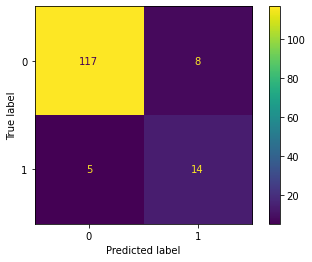

In [45]:
from sklearn.metrics import make_scorer, f1_score, accuracy_score
predictions = svc.predict(features_test)
cm = confusion_matrix(y_test, predictions, labels=svc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc.classes_)
disp.plot()
print(f1_score(y_test, predictions))
print(accuracy_score(y_test, predictions))

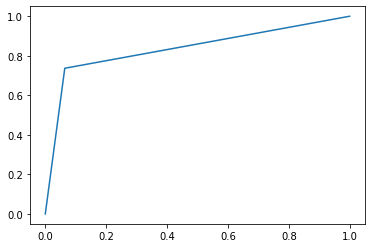

In [46]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=1)
plt.plot(fpr, tpr)

In [47]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, predictions)

0.836421052631579

0.8648648648648649


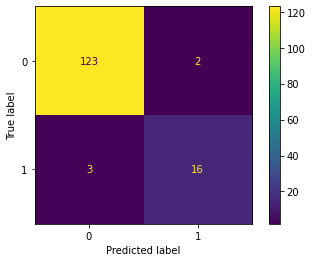

In [48]:
from sklearn.tree import DecisionTreeClassifier
dTree = DecisionTreeClassifier(criterion= 'entropy', max_depth = 4)
dTree.fit(X, y)
prediction_s = dTree.predict(features_test)
cd = confusion_matrix(y_test, prediction_s, labels=dTree.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cd, display_labels=dTree.classes_)
disp.plot()
print(f1_score(y_test, prediction_s))

In [49]:
features_test

,cOfVar,peakMonth,minMonth,c_labels
20,0.297487,0,1,8
132,0.280901,5,0,4
87,0.506359,4,8,10
52,0.499087,4,0,12
13,0.046254,0,4,5
...,...,...,...,...
259,0.414755,9,3,8
80,0.066121,2,4,0
43,0.145082,9,4,4
139,0.073699,1,0,10


In [50]:
y_test

20     0
132    0
87     0
52     0
13     0
      ..
259    0
80     0
43     0
139    0
264    0
Name: label, Length: 144, dtype: int64

0.9230769230769231
0.9791666666666666


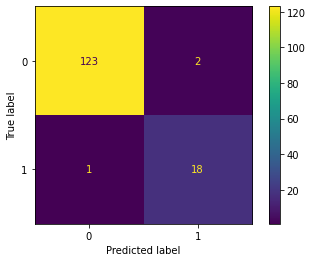

In [51]:
import xgboost as xgb
boost = xgb.XGBClassifier()
boost.fit(X, y)
predictions_b = boost.predict(features_test)
cm_b = confusion_matrix(y_test, predictions_b, labels=boost.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_b, display_labels=boost.classes_)
disp.plot()
print(f1_score(y_test, predictions_b))
print(accuracy_score(y_test, predictions_b))

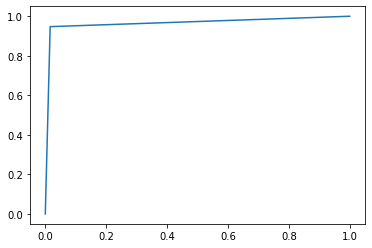

In [52]:
from sklearn import metrics
fpr_xg_test, tpr_xg_test, thresholds_xg_test = metrics.roc_curve(y_test, predictions_b, pos_label=1)
plt.plot(fpr_xg_test, tpr_xg_test)

In [53]:
roc_auc_score(y_test, predictions_b)

0.9656842105263157

In [54]:
train

,0,1,2,3,4,5,6,7,8,9,10,11
0,19.000000,19.000000,115.000000,58.000000,29.00000,19.000000,19.000000,115.000000,58.000000,29.000000,115.000000,58.000000
1,27.000000,24.000000,37.000000,40.000000,30.00000,22.000000,27.000000,24.000000,6.000000,29.000000,24.000000,6.000000
2,30.000000,28.000000,32.000000,29.000000,36.00000,36.000000,44.000000,40.000000,40.000000,44.000000,40.000000,40.000000
3,20.000000,19.000000,35.000000,37.000000,41.00000,20.000000,19.000000,35.000000,37.000000,41.000000,35.000000,37.000000
4,7.000000,7.000000,6.000000,13.000000,18.00000,7.000000,0.000000,13.000000,18.000000,27.000000,13.000000,18.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
371,222.049514,240.717434,222.802204,275.279327,252.41711,251.392353,236.364097,248.473623,204.996501,167.950486,181.134284,239.667920
372,55.456401,35.058645,1.912290,0.000000,0.00000,16.573177,22.310047,54.672617,105.239673,101.327383,123.631822,117.421215
373,113.582136,87.526494,3.560813,56.739087,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
374,84.899131,53.671864,2.927556,0.000000,0.00000,25.372154,34.154823,66.178971,94.748586,89.821029,151.044018,135.696012


0.744186046511628


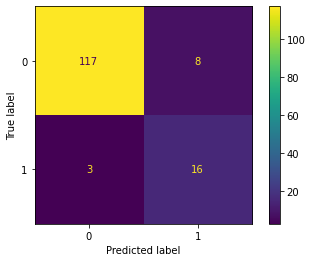

In [55]:
boost_raw =xgb.XGBClassifier()
boost_raw.fit(train, y_train)
prediction_raw = boost_raw.predict(X_test)
cm = confusion_matrix(y_test, prediction_raw, labels=boost.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=boost.classes_)
disp.plot()
print(f1_score(y_test,prediction_raw))

In [56]:
roc_auc_score(y_test, prediction_raw)

0.8890526315789473

In [57]:
# from sklearn import metrics
# fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=1)
# plt.plot(fpr, tpr)

0.81,0.84, 0.92, 0.7,0.76, 0.78, 0.75, 0.72, 0.68, 0.79

In [58]:
xgb_params = {
    "n_estimators" : [5,10, 50, 100, 200, 300, 500],
    "learning_rate": [0.01, 0.03, 0.05,  0.1, 0.3, 0.5],
    "num_leaves" : [1,5,10, 20, 30, 40, 50, 80, 100]
}
searcher = GridSearchCV(boost, n_jobs=-1, cv=3,
	param_grid=xgb_params, scoring="accuracy")
searchResults = searcher.fit(X, y)


In [59]:
print(searchResults.best_score_)
print(searchResults.best_params_)

0.9308148148148149
{'learning_rate': 0.05, 'n_estimators': 300, 'num_leaves': 1}


0.9758713136729222


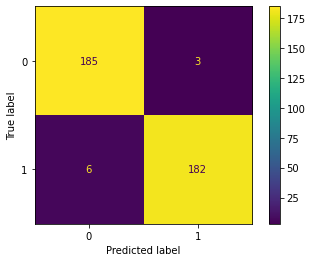

In [60]:
prediction_train = boost.predict(X)
cm_t = confusion_matrix(y, prediction_train, labels=boost.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_t, display_labels=boost.classes_)
disp.plot()
print(f1_score(y, prediction_train))

In [61]:
roc_auc_score(y, prediction_train)

0.976063829787234

0.6829268292682926
0.9097222222222222


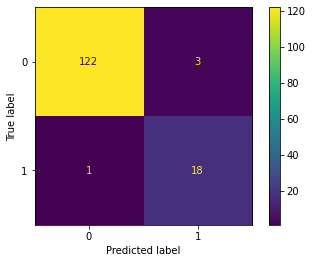

In [62]:
from sklearn.model_selection import RepeatedStratifiedKFold
import lightgbm as lgb
from  lightgbm import LGBMClassifier

model_lgbm = lgb.LGBMClassifier()
model_lgbm.fit(X, y)
prediction_lgb = model_lgbm.predict(features_test)
cm = confusion_matrix(y_test, prediction_lgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
print(f1_score(y_test, predictions))
print(accuracy_score(y_test, predictions))

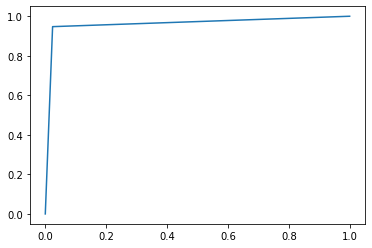

In [63]:
from sklearn import metrics
fpr_lgb, tpr_lgb, thresholds_lgb = metrics.roc_curve(y_test, prediction_lgb, pos_label=1)
plt.plot(fpr_lgb, tpr_lgb)

In [64]:
roc_auc_score(y_test, prediction_lgb)

0.9616842105263157

0.7555555555555555


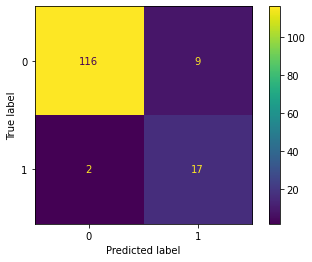

In [65]:
lgb_raw =lgb.LGBMClassifier()
lgb_raw.fit(train, y_train)
prediction_rawl = lgb_raw.predict(X_test)
cm = confusion_matrix(y_test, prediction_rawl, labels=boost.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=boost.classes_)
disp.plot()
print(f1_score(y_test,prediction_rawl))

In [66]:
lgbm_params = {
    "n_estimators" : [5,10, 50, 100, 200, 300, 500],
    "learning_rate": [0.01, 0.03, 0.05,  0.1, 0.3, 0.5],
    "num_leaves" : [5,10, 20, 30, 40, 50, 80, 100]
}
searcher = GridSearchCV(model_lgbm, n_jobs=-1, cv=5,
	param_grid=lgbm_params, scoring="accuracy")
searchResults = searcher.fit(X_test, y_test)


In [67]:
print(searchResults.best_score_)
print(searchResults.best_params_)

0.9305418719211822
{'learning_rate': 0.5, 'n_estimators': 100, 'num_leaves': 5}


0.9973474801061007


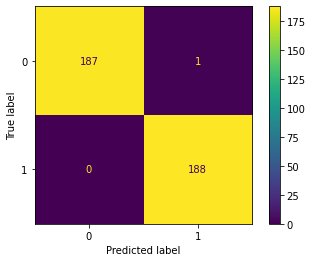

In [68]:
prediction_train = model_lgbm.predict(X)
cm_t = confusion_matrix(y, prediction_train, labels=model_lgbm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_t, display_labels=model_lgbm.classes_)
disp.plot()
print(f1_score(y, prediction_train))

Comparison between Using the XGBoost Classifier on raw time-series data and the newly engineered features

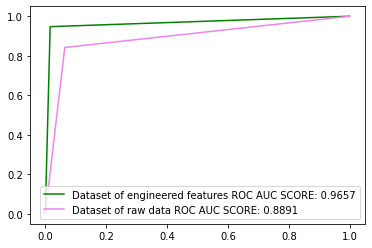

In [69]:
fpr_xg_raw, tpr_xg_raw, thresholds_xg_raw = metrics.roc_curve(y_test, prediction_raw, pos_label=1)
plt.plot(fpr_xg_test, tpr_xg_test, color = 'green', label = 'Dataset of engineered features ROC AUC SCORE: 0.9657')
plt.plot(fpr_xg_raw, tpr_xg_raw, color = 'violet', label = 'Dataset of raw data ROC AUC SCORE: 0.8891')
plt.legend(loc="lower right")

Comparison of all classifiers on the Test Data

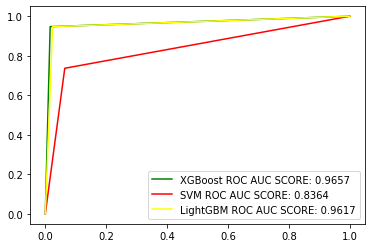

In [70]:
fpr_xg_train, tpr_xg_train, thresholds_xg_train = metrics.roc_curve(y, prediction_train, pos_label=1)
plt.plot(fpr_xg_test, tpr_xg_test, color = 'green', label = 'XGBoost ROC AUC SCORE: 0.9657')
plt.plot(fpr, tpr, color = 'red', label = 'SVM ROC AUC SCORE: 0.8364')
plt.plot(fpr_lgb, tpr_lgb, color = 'yellow', label = 'LightGBM ROC AUC SCORE: 0.9617')
plt.legend(loc="lower right")
plt.show()

Comparison between Using the Training and Test data for XGBoost Classifier

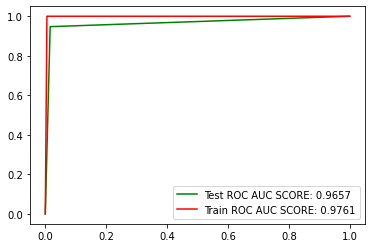

In [71]:
fpr_xg_train, tpr_xg_train, thresholds_xg_train = metrics.roc_curve(y, prediction_train, pos_label=1)
plt.plot(fpr_xg_test, tpr_xg_test, color = 'green', label = 'Test ROC AUC SCORE: 0.9657')
plt.plot(fpr_xg_train, tpr_xg_train, color = 'red', label = 'Train ROC AUC SCORE: 0.9761')
plt.legend(loc="lower right")